In [1]:
import os
from bs4 import BeautifulSoup 
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
import seaborn as sns

from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

/Users/rajithamuthukrishnan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Helper Functions for Data

In [2]:
def extract_filenames(path):
    files = [] 
    for filename in os.listdir(path):
        if not filename.endswith('.xml'):
            continue
        filepath = os.path.join(path, filename)
        files.append(filepath)
    return files

def extract_train_chunks():
    dataframe_collection = {} 
    for ctr in range(1,11):
        positive_file_path = "/Users/rajithamuthukrishnan/Desktop/uOttawa/Project_CSI6900/dataset/erisk 2019/eRisk2019_T1/training data - t1/2018 train/positive_examples/chunk"+str(ctr)
        negative_file_path = "/Users/rajithamuthukrishnan/Desktop/uOttawa/Project_CSI6900/dataset/erisk 2019/eRisk2019_T1/training data - t1/2018 train/negative_examples/chunk"+str(ctr)
        positive_files = extract_filenames(positive_file_path)
        negative_files = extract_filenames(negative_file_path)
        files = positive_files + negative_files
        data_list = []
        for file in files:
            if 'positive' in file:
                label = 1
            elif 'negative' in file:
                label = 0
            fd = open(file,'r')
            data = fd.read()
            soup = BeautifulSoup(data,'xml')
            subject_id = soup.find('ID')
            writings = soup.find_all('WRITING')
            title = ''
            text = ''
            for writing in writings:
                title = title + writing.find('TITLE').get_text() + ' '
                text = text + writing.find('TEXT').get_text() + ' '
                row = [subject_id.get_text(), title, text, label]
            data_list.append(row)
        chunk_name = 'chunk'+str(ctr)
        dataframe_collection[chunk_name] = pd.DataFrame(data_list, columns = ['subject_id', 'title', 'text', 'label'])
    return dataframe_collection

def stemSentence(sentence):
    lemmatizer=WordNetLemmatizer()
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# Preprocess, encode data (word embeddings) for every chunk
def preprocess_data(df):
#   TITLE CLEAN
    df['title_clean'] = df['title'].loc[df['title'] ==  ' [removed] '] = ' '
    df['title_clean'] = df['title'].str.lower()
    df['title_clean'] = df['title_clean'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df['title_clean'] = df['title_clean'].apply(lambda elem: re.sub(r"\d+", "", elem))
    # remove duplicate spaces
    df['title_clean'] = df['title_clean'].apply(lambda elem: re.sub(' +', ' ', elem))
    # remove stop words
    df['title_clean'] = df['title_clean'].apply(lambda elem: remove_stopwords(elem))
    df['title_clean'] = df['title_clean'].apply(lambda elem: stemSentence(elem))
    
#   TEXT CLEAN
    df['text_clean'] = df['text'].loc[df['title'] ==  ' [removed] '] = ' '
    df['text_clean'] = df['text'].str.lower()
    df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(r"\d+", "", elem))
    # remove duplicate spaces
    df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(' +', ' ', elem))
    # remove stop words
    df['text_clean'] = df['text_clean'].apply(lambda elem: remove_stopwords(elem))
    df['text_clean'] = df['text_clean'].apply(lambda elem: stemSentence(elem))
    
    df['final_text'] = df['title_clean'] + df['text_clean']
    
    final_dataset = pd.DataFrame(df['subject_id'])
    final_dataset['text'] = df['title_clean'] + ' ' + df['final_text']
    if 'label' in df.columns:
        final_dataset['label'] = df['label']
    
    return final_dataset

In [3]:
def word_cloud_chunks(train_df_collection):
    for chunk in range (len(train_df_collection)):
        chunk_name = 'chunk'+str(chunk+1)
        print('*** Chunk '+str(chunk+1)+' ***')
        positive_data = preprocess_data(train_df_collection[chunk_name][train_df_collection[chunk_name].label==1])
        text = " ".join(text for text in positive_data.text)
        
        wordcloud = WordCloud(collocations = False, background_color = 'white',
                              width = 2048, height = 1080).generate(text)
        plt.figure(figsize=(15,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
def word_cloud(train_df_collection):
    train_df = train_df_collection['chunk1']
    for chunk in range (1, len(train_df_collection)):
        chunk_name = 'chunk'+str(chunk)
        train_df = train_df.append(train_df_collection[chunk_name])
            

    positive_data = preprocess_data(train_df[train_df.label==1])
    text = " ".join(text for text in positive_data.text)
        
    wordcloud = WordCloud(collocations = False, background_color = 'white',
                          width = 2048, height = 1080).generate(text)
    
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

## Extract Data

In [4]:
# Train Data - Chunks 1 - 9
train_dataframe_collection = extract_train_chunks()

## Data Analysis

### Imbalanced Data

<AxesSubplot:xlabel='label', ylabel='count'>

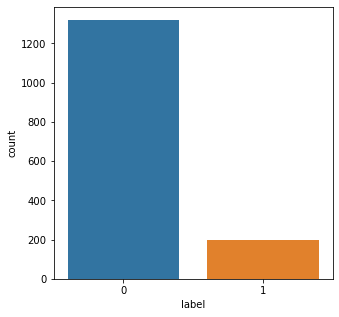

In [5]:
df = train_dataframe_collection['chunk1']
for chunk in range (1, len(train_dataframe_collection)):
    chunk_name = 'chunk'+str(chunk)
    df = df.append(train_dataframe_collection[chunk_name])
plt.figure(figsize=(5,5))
sns.countplot(df.label)

### Word Cloud

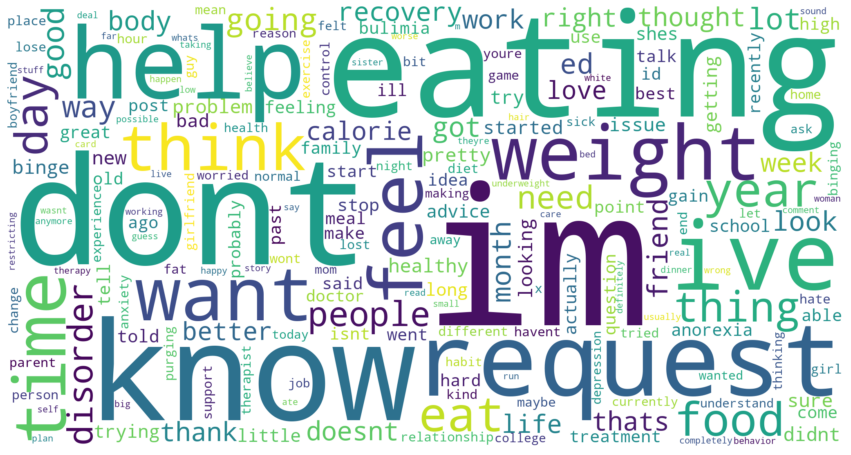

In [6]:
word_cloud(train_dataframe_collection)

### Chunk wise Word Cloud

*** Chunk 1 ***


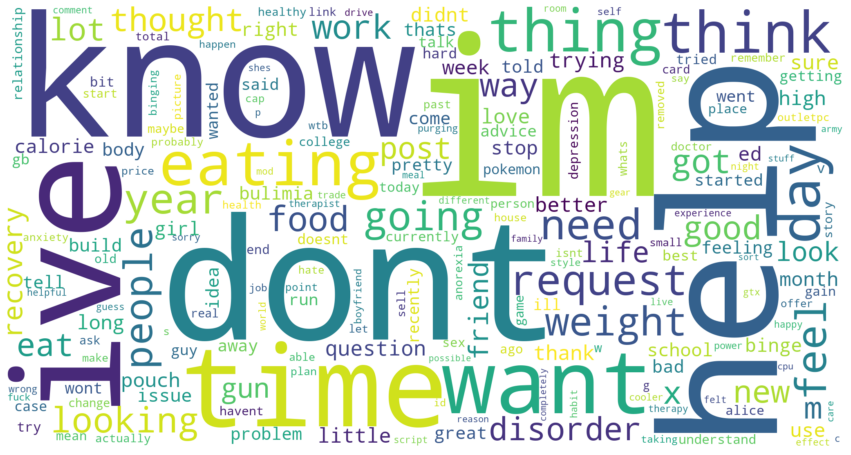

*** Chunk 2 ***


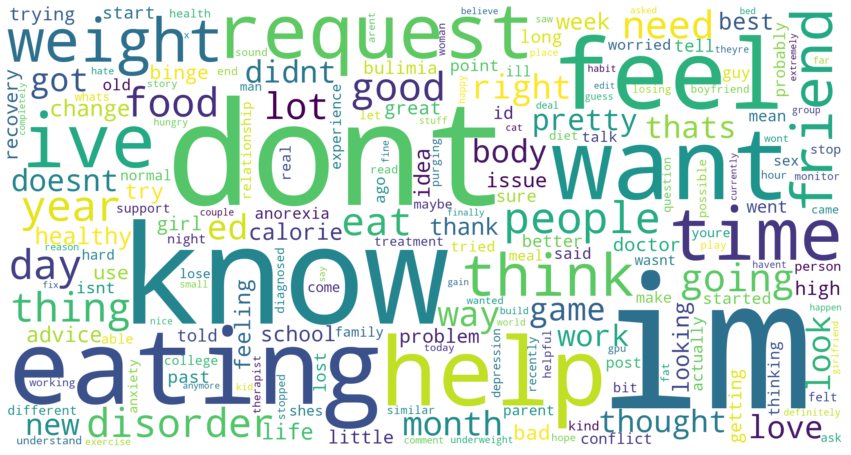

*** Chunk 3 ***


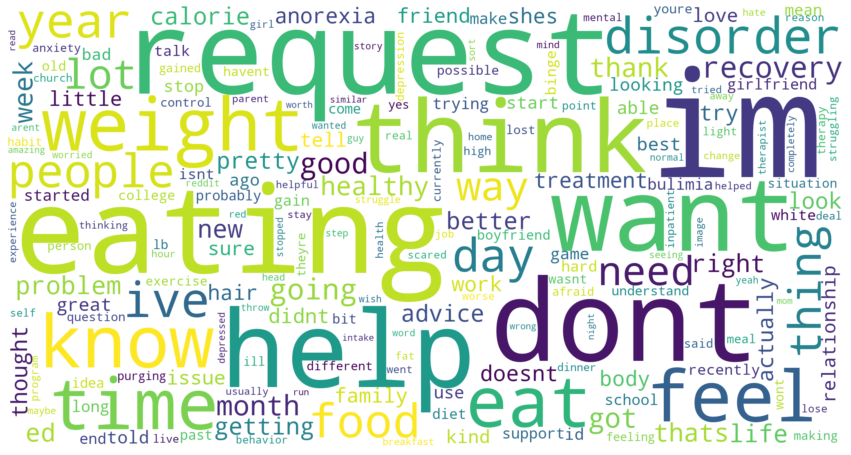

*** Chunk 4 ***


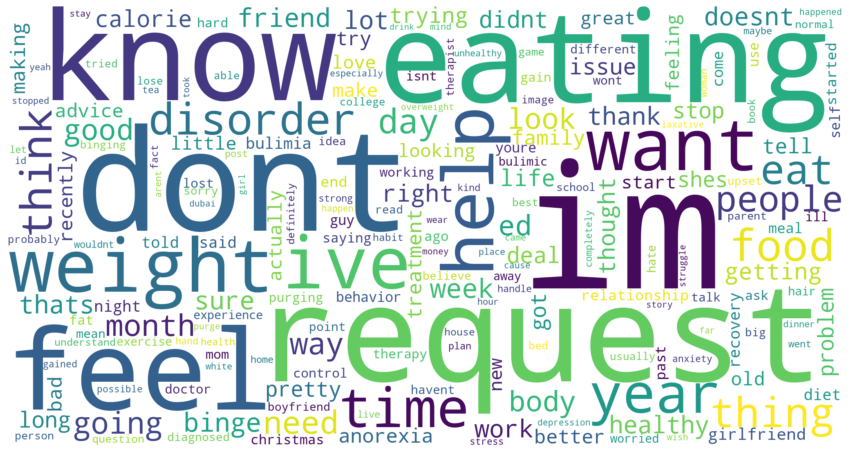

*** Chunk 5 ***


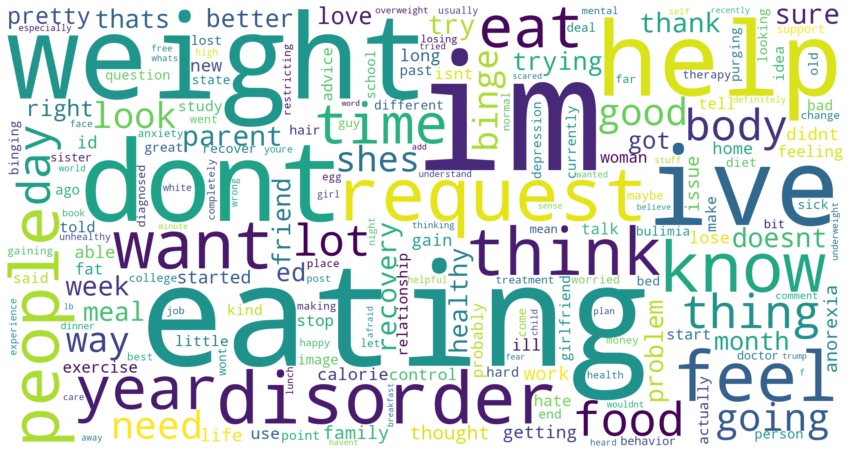

*** Chunk 6 ***


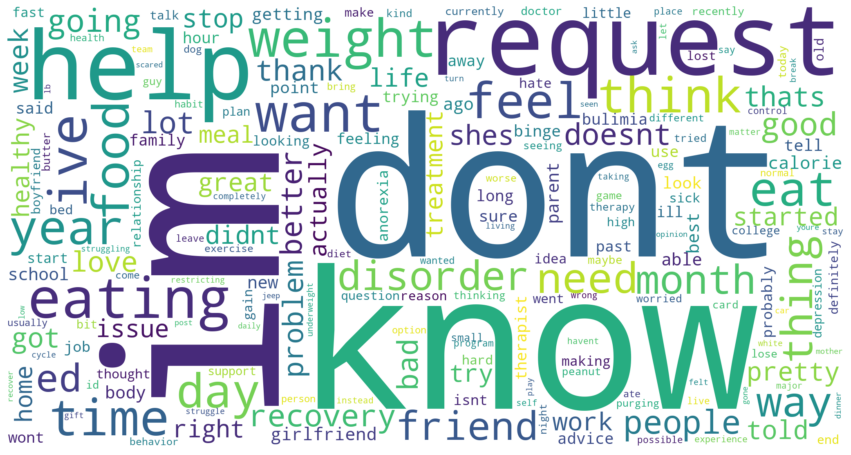

*** Chunk 7 ***


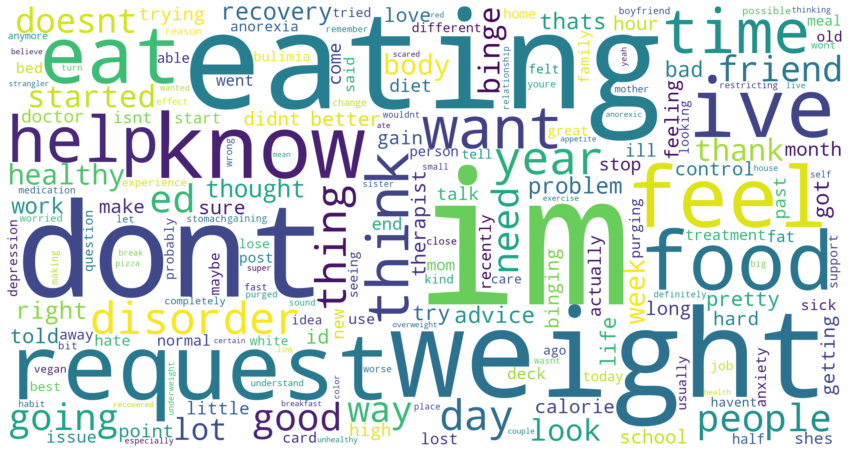

*** Chunk 8 ***


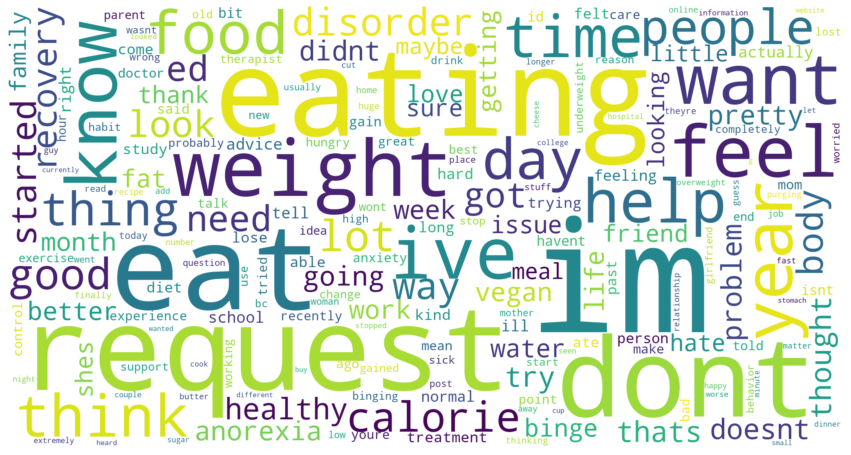

*** Chunk 9 ***


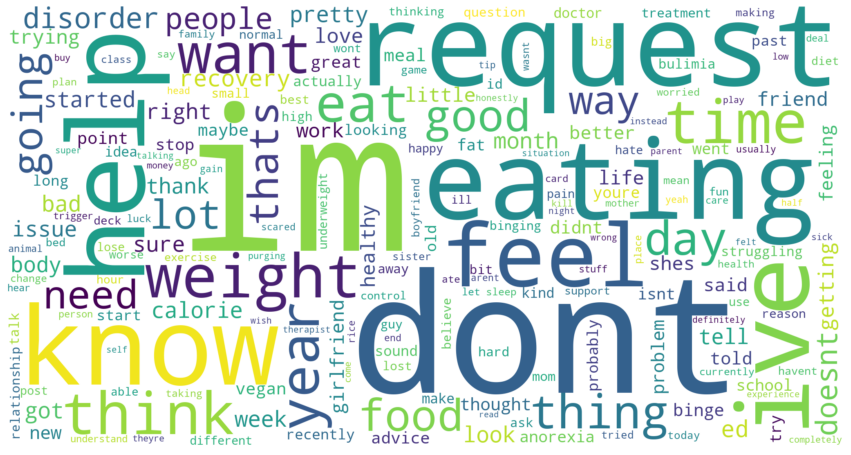

*** Chunk 10 ***


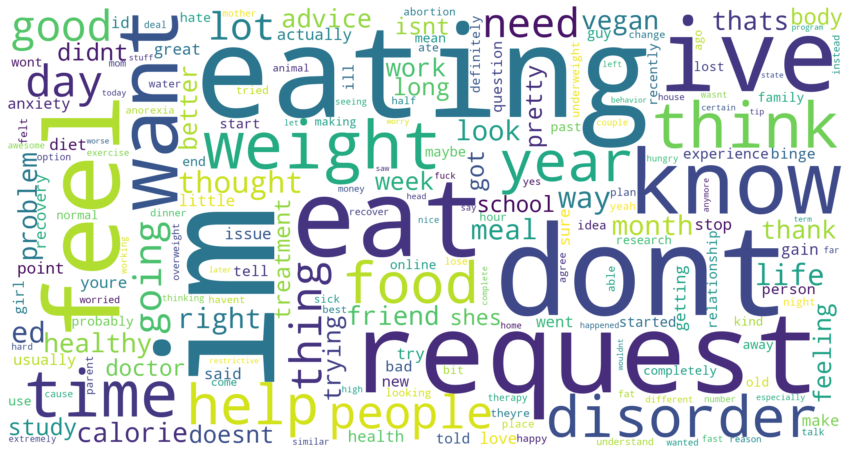

In [7]:
word_cloud_chunks(train_dataframe_collection)